In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from sklearn.metrics import mean_squared_error

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('allBank_balance_101_sector.csv',',', index_col=['report_date'], parse_dates=['report_date'], dayfirst=True)
print(df.shape)
df.head()

(215564, 4)


,sector_id,bank_group_id,value_rub,value_usd
report_date,,,,
2007-02-01,40,6,9.408740,8.925271
2007-02-01,10,6,31.943854,36.274318
2007-02-01,41,6,48.045392,20.535636
2007-02-01,12,6,4.604419,15.616651
2007-02-01,15,6,0.041111,0.000002


In [3]:
df.tail()

,sector_id,bank_group_id,value_rub,value_usd
report_date,,,,
2019-05-01,53,66,0.345000,0.046932
2019-05-01,54,66,12.070842,4.746029
2019-05-01,44,66,0.000140,0.000000
2019-05-01,46,66,0.000140,0.000000
2019-05-01,42,66,2.008601,0.000000


### Визуальный анализ ряда

In [4]:
sector_1 = df[(df['bank_group_id'] == 1) & (df['sector_id'] == 1)]
sector_1 = sector_1.reindex(pd.date_range(sector_1.index.min(), sector_1.index.max(), freq='MS'), fill_value=0)
sector_2 = df[(df['bank_group_id'] == 1) & (df['sector_id'] == 2)]
sector_3 = df[(df['bank_group_id'] == 1) & (df['sector_id'] == 3)]
sector_4 = df[(df['bank_group_id'] == 1) & (df['sector_id'] == 4)]

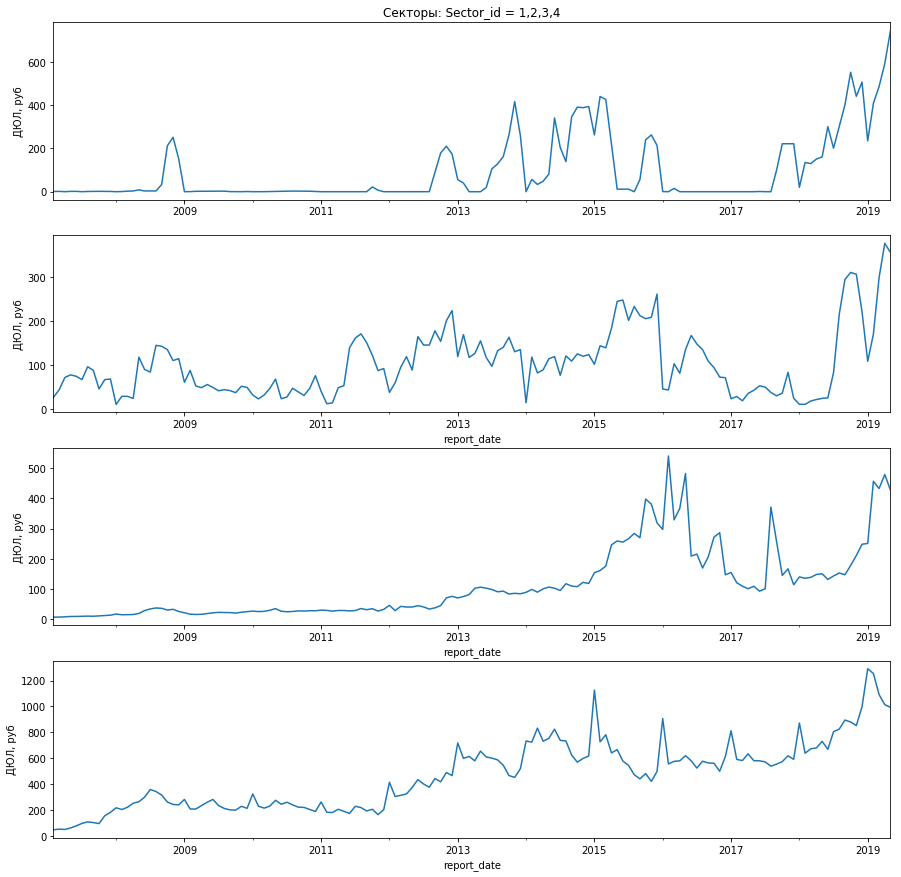

In [5]:
plt.figure(figsize=(15, 15))
plt.subplot(4, 1, 1)
plt.title("Секторы: Sector_id = 1,2,3,4") # заголовок
sector_1['value_rub'].plot()
plt.ylabel('ДЮЛ, руб')
plt.subplot(4, 1, 2)
sector_2['value_rub'].plot()
plt.ylabel('ДЮЛ, руб') 
plt.subplot(4, 1, 3)
sector_3['value_rub'].plot()
plt.ylabel('ДЮЛ, руб')
plt.subplot(4, 1, 4)
sector_4['value_rub'].plot()
plt.ylabel('ДЮЛ, руб')
pylab.show() 

## Работа с рядом суммы секторов

In [6]:
sectors = df[(df['bank_group_id'] == 1) & ((df['sector_id'] == 1) | (df['sector_id'] == 2) | (df['sector_id'] == 3) | (df['sector_id'] == 4))]
sectors.head(10)

,sector_id,bank_group_id,value_rub,value_usd
report_date,,,,
2007-02-01,2,1,27.283416,0.053730
2007-02-01,1,1,0.920018,0.000000
2007-02-01,3,1,7.342596,0.567342
2007-02-01,4,1,47.034125,154.252131
2007-03-01,2,1,44.244502,0.037278
2007-03-01,1,1,1.580018,0.000000
2007-03-01,3,1,7.490046,0.588589
2007-03-01,4,1,52.539326,152.972843
2007-04-01,2,1,72.162548,0.052673


In [7]:
sectors.tail(10)

,sector_id,bank_group_id,value_rub,value_usd
report_date,,,,
2019-03-01,3,1,432.526744,20.907912
2019-03-01,4,1,1091.570783,2799.597641
2019-04-01,1,1,592.118110,0.000000
2019-04-01,2,1,376.641710,0.067334
2019-04-01,3,1,478.840509,20.353461
2019-04-01,4,1,1014.314101,2671.484733
2019-05-01,1,1,744.952791,0.000000
2019-05-01,2,1,355.714828,0.067012
2019-05-01,3,1,426.952758,22.462389


In [8]:
sectors_sum = sectors.groupby('report_date')['value_rub'].sum()
sectors_sum = sectors_sum.to_frame()
sectors_sum.head()

,value_rub
report_date,
2007-02-01,82.580155
2007-03-01,105.853892
2007-04-01,130.690753
2007-05-01,150.535440
2007-06-01,163.969009


Text(0, 0.5, 'ДЮЛ, руб.')

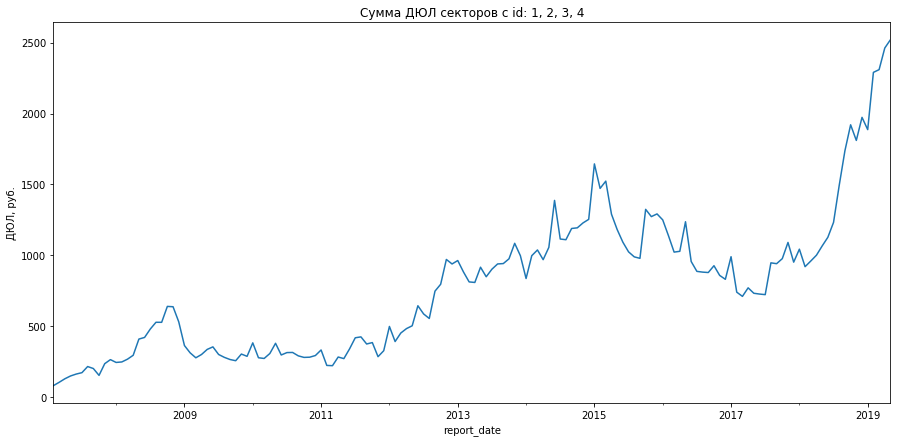

In [9]:
plt.figure(figsize=(15, 7))
plt.title("Сумма ДЮЛ секторов с id: 1, 2, 3, 4") 
sectors_sum.value_rub.plot()
plt.ylabel('ДЮЛ, руб.')

Критерий Дики-Фуллера: p=0.994667


<Figure size 864x576 with 0 Axes>

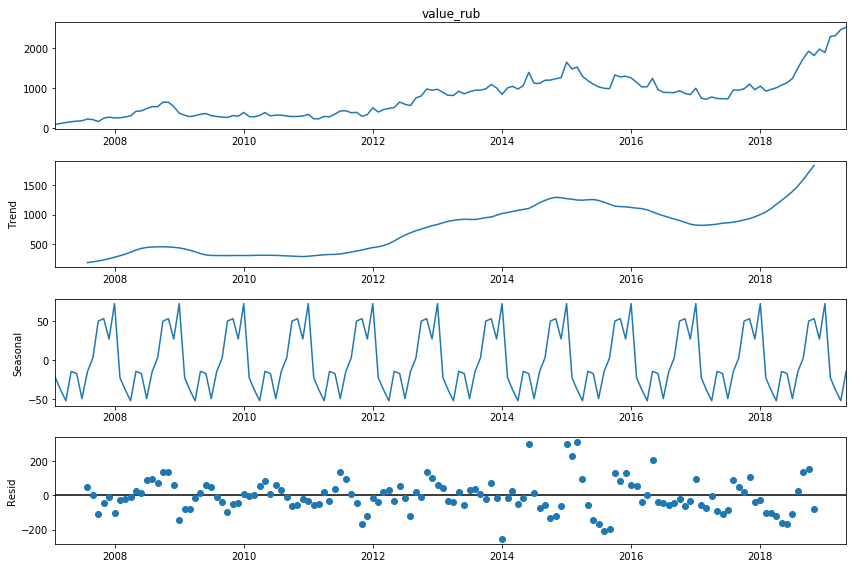

In [10]:
plt.figure(figsize(12,8))
sm.tsa.seasonal_decompose(sectors_sum.value_rub).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sectors_sum.value_rub)[1])

### Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.234975
Критерий Дики-Фуллера: p=0.624028


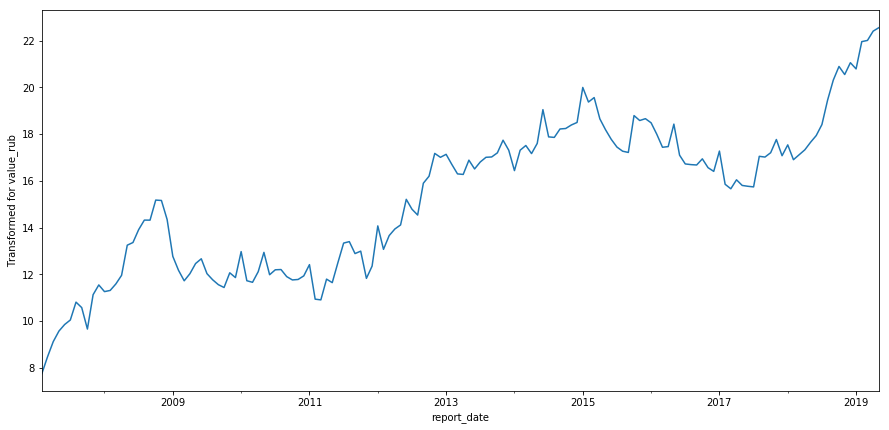

In [11]:
sectors_sum['value_rub_box'], lmbda = stats.boxcox(sectors_sum.value_rub)
plt.figure(figsize(15,7))
sectors_sum.value_rub_box.plot()
plt.ylabel(u'Transformed for value_rub')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sectors_sum.value_rub_box)[1])

### Стационарность

Критерий Дики-Фуллера: p=0.383340


<Figure size 864x576 with 0 Axes>

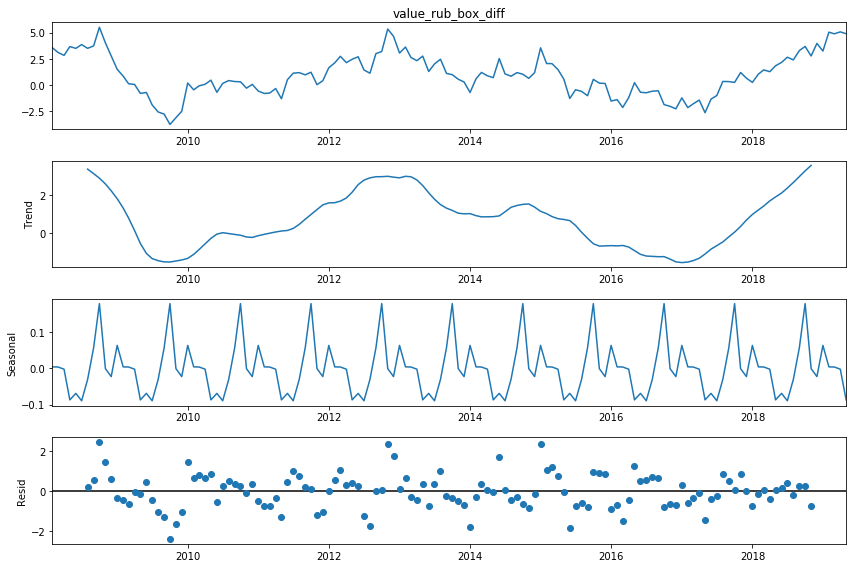

In [12]:
sectors_sum['value_rub_box_diff'] = sectors_sum.value_rub_box - sectors_sum.value_rub_box.shift(12)
plt.figure(figsize(12,8))
sm.tsa.seasonal_decompose(sectors_sum.value_rub_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sectors_sum.value_rub_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.001357


<Figure size 864x576 with 0 Axes>

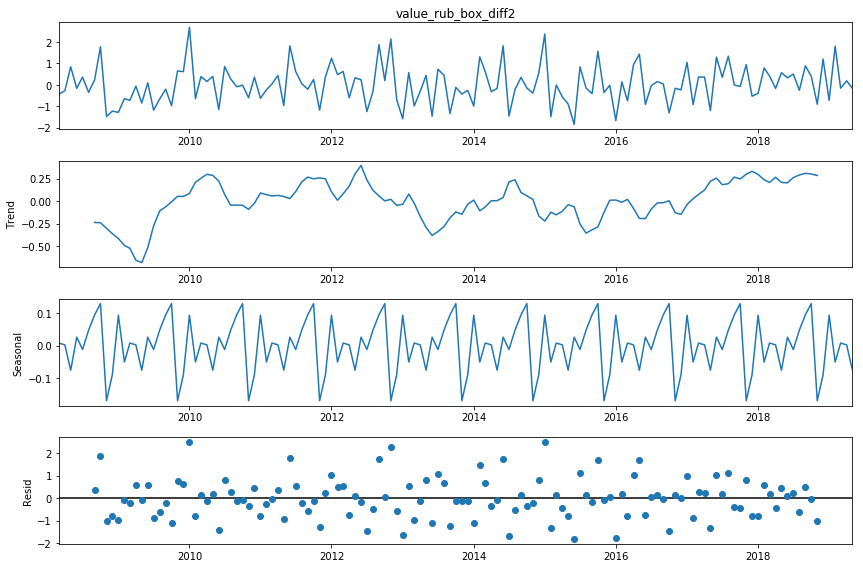

In [13]:
sectors_sum['value_rub_box_diff2'] = sectors_sum.value_rub_box_diff - sectors_sum.value_rub_box_diff.shift(1)
plt.figure(figsize(12,8))
sm.tsa.seasonal_decompose(sectors_sum.value_rub_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sectors_sum.value_rub_box_diff2[13:])[1])

### Подбор модели

#### Выбор начальных приближений для p, q, P, Q

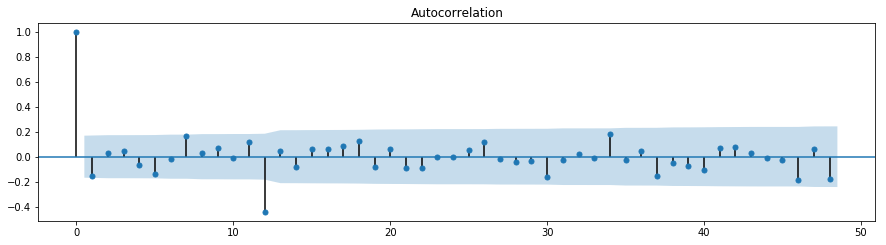

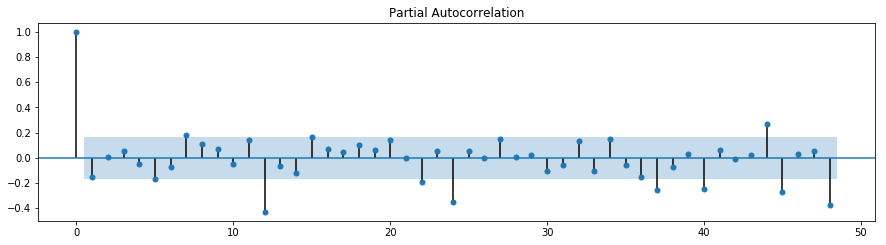

In [14]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(sectors_sum.value_rub_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(sectors_sum.value_rub_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=1, P=4, p=1

In [15]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

In [16]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

40

In [17]:
results = []
best_aic = float("inf")

from tqdm import tqdm
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sectors_sum.value_rub_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|██████████████████████████████████████████| 40/40 [07:23<00:00, 29.75s/it]


In [18]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
9   (0, 0, 4, 1)  288.569824
19  (0, 1, 4, 1)  290.373454
29  (1, 0, 4, 1)  290.403395
8   (0, 0, 4, 0)  290.965316
1   (0, 0, 0, 1)  291.667699


In [19]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                        value_rub_box   No. Observations:                  148
Model:             SARIMAX(0, 1, 0)x(4, 1, [1], 12)   Log Likelihood                -138.285
Date:                              Tue, 28 Jul 2020   AIC                            288.570
Time:                                      18:05:20   BIC                            306.001
Sample:                                  02-01-2007   HQIC                           295.654
                                       - 05-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4384      0.146     -3.010      0.003      -0.724      -0.153
ar.S.L24      -0.42

In [17]:
model=sm.tsa.statespace.SARIMAX(sectors_sum.value_rub_box, order=(0, 1, 0), 
                                        seasonal_order=(4, 1, 1, 12)).fit(disp=-1)
best_model = model

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


#### Анализ остатков построенной модели

Критерий Стьюдента: p=0.510901
Критерий Дики-Фуллера: p=0.000000


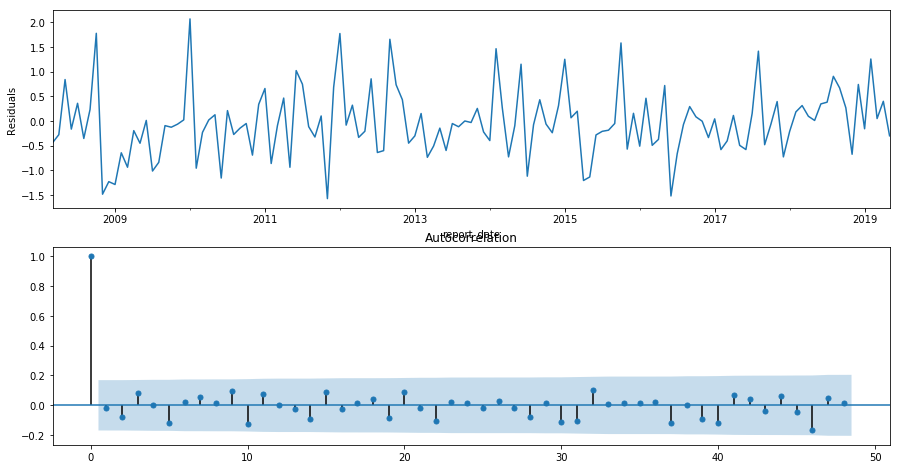

In [18]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

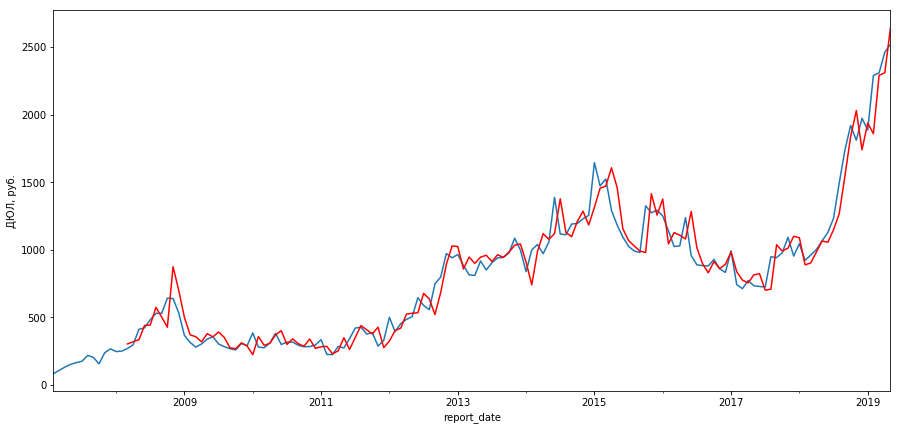

In [19]:
sectors_sum['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
sectors_sum.value_rub.plot()
sectors_sum.model[13:].plot(color='r')
plt.ylabel('ДЮЛ, руб.')
pylab.show()

In [ ]:
# sec_sum = sectors_sum[['value_rub']]
# date_list = [datetime.datetime.strptime("2019-06-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
# future = pd.DataFrame(index=date_list, columns= sec_sum.columns)
# sec_sum = pd.concat([sec_sum, future])
# sec_sum['forecast'] = invboxcox(best_model.predict(start=148, end=160), lmbda)

# plt.figure(figsize(15,7))
# sec_sum.value_rub.plot()
# sec_sum.forecast.plot(color='r')
# plt.ylabel('ДЮЛ, руб.')
# pylab.show()

## Бэк-тест

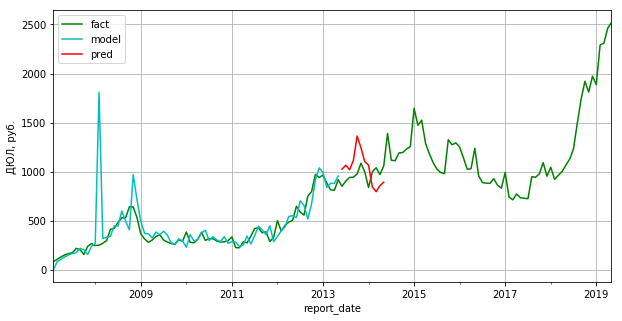

RMSE: 194.35882212931642


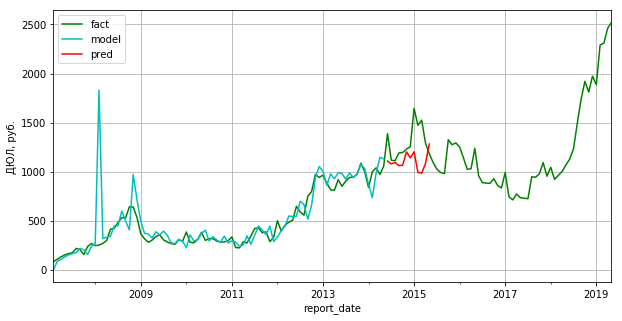

RMSE: 273.86150916567243


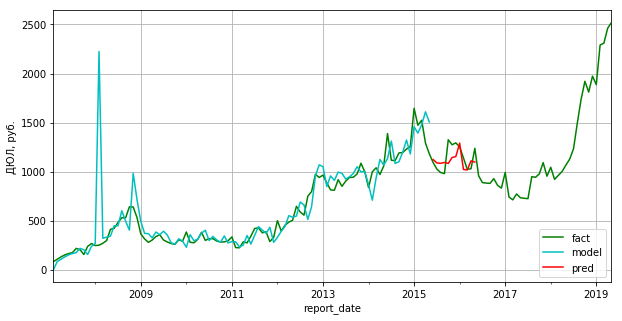

RMSE: 116.65010918414644


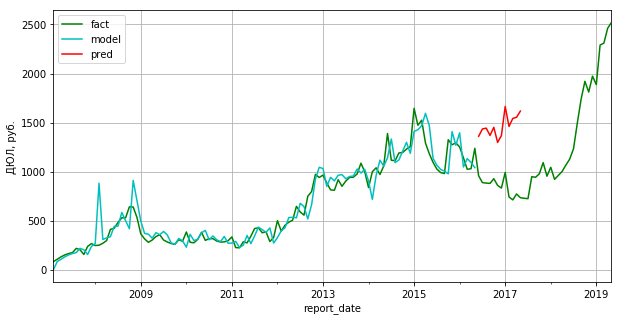

RMSE: 633.7226863482645


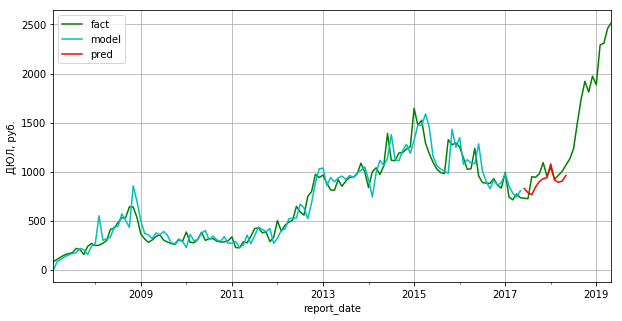

RMSE: 99.06903136264394


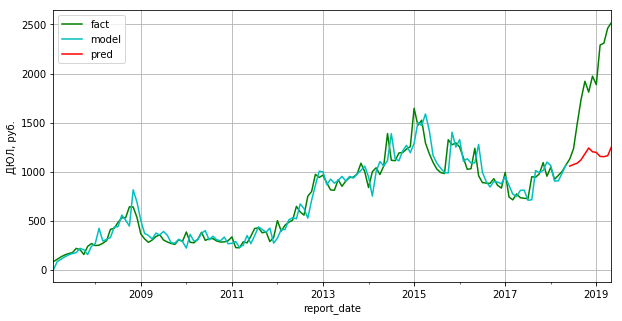

RMSE: 839.2700021405956

Средняя RMSE на исторических данных для горизонта прогнозирования в 1 год: 359.4886933884399


In [26]:
warnings.filterwarnings('ignore')

rmse_arr = []
sec_sum = sectors_sum[['value_rub']]

for i in range(0, 72, 12):
    
    time_lapse = int(len(sectors_sum)/2) + 2 + i
    train, lmbda = stats.boxcox(sectors_sum.value_rub[:time_lapse])
    model=sm.tsa.statespace.SARIMAX(train, order=(0, 1, 0), 
                                        seasonal_order=(4, 1, 1, 12)).fit(disp=-1)
    best_model = model
    
    sec_sum['model'] = np.nan
    sec_sum['forecast'] = np.nan
    
    if len(sectors_sum) - time_lapse < 12:
        end = len(sectors_sum) - time_lapse - 1
        sec_sum['model'][:time_lapse] = invboxcox(best_model.fittedvalues, lmbda)
        sec_sum['forecast'][time_lapse:]  = invboxcox(best_model.predict(start=time_lapse, end=time_lapse+end), lmbda)
    else:
        sec_sum['model'][:time_lapse] = invboxcox(best_model.fittedvalues, lmbda)
        sec_sum['forecast'][time_lapse:(time_lapse+12)]  = invboxcox(best_model.predict(start=time_lapse, end=time_lapse+11), lmbda)
        
    plt.figure(figsize(10,5))
    sec_sum.value_rub.plot(label = 'fact', color='g')
    sec_sum.model.plot(label = 'model', color='c')
    sec_sum.forecast.plot(label = 'pred', color='r')
    plt.ylabel('ДЮЛ, руб.')
    plt.legend()
    plt.grid()
    pylab.show()
    
    if len(sectors_sum) - time_lapse < 12:
        y_true = sec_sum['value_rub'][time_lapse:]
        y_pred = sec_sum['forecast'][time_lapse:]
    else:
        y_true = sec_sum['value_rub'][time_lapse:(time_lapse + 12)]
        y_pred = sec_sum['forecast'][time_lapse:(time_lapse + 12)]
        
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE:', rmse)
    rmse_arr.append(rmse)

print('\nСредняя RMSE на исторических данных для горизонта прогнозирования в 1 год:', np.mean(rmse_arr))

## Прогноз

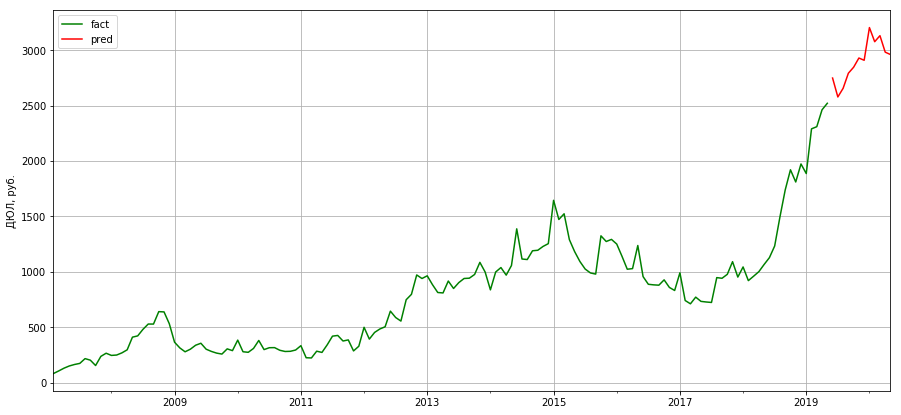

In [27]:
_, lmbda = stats.boxcox(sectors_sum.value_rub)

model=sm.tsa.statespace.SARIMAX(_, order=(0, 1, 0), 
                                        seasonal_order=(4, 1, 1, 12)).fit(disp=-1)
best_model = model

sec_sum = sectors_sum[['value_rub']]

date_list = [datetime.datetime.strptime("2019-06-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= sec_sum.columns)
sec_sum = pd.concat([sec_sum, future])
sec_sum['forecast'] = np.nan

sec_sum['forecast'][-12:] = invboxcox(best_model.predict(start=148, end=159), lmbda)

plt.figure(figsize(15,7))
sec_sum.value_rub.plot(label = 'fact', color='g')
sec_sum.forecast.plot(label = 'pred', color='r')
plt.ylabel('ДЮЛ, руб.')
plt.legend()
plt.grid()
pylab.show()

## Вывод: 
Видно, что на бэк-тесте модель работает средне. 
Попробуем построить модель для каждый сектора по отдельности и затем сложить результат. 

In [ ]:
sector_1 = df[(df['bank_group_id'] == 1) & (df['sector_id'] == 1)]
sector_1 = sector_1.reindex(pd.date_range(sector_1.index.min(), sector_1.index.max(), freq='MS'), fill_value=0)
sector_2 = df[(df['bank_group_id'] == 1) & (df['sector_id'] == 2)]
sector_3 = df[(df['bank_group_id'] == 1) & (df['sector_id'] == 3)]
sector_4 = df[(df['bank_group_id'] == 1) & (df['sector_id'] == 4)]

## Sector_id - 1

In [ ]:
sector_1['value_rub'][sector_1['value_rub'] == 0] = 0.00000000000001

In [ ]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(sector_1.value_rub).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_1.value_rub)[1])

In [ ]:
sector_1['value_rub_box'], lmbda = stats.boxcox(sector_1.value_rub)
plt.figure(figsize(15,7))
sector_1.value_rub_box.plot()
plt.ylabel(u'Transformed for value_rub')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_1.value_rub_box)[1])

In [ ]:
warnings.filterwarnings('ignore')

sector_1['value_rub_box_diff'] = sector_1.value_rub_box - sector_1.value_rub_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(sector_1.value_rub_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_1.value_rub_box_diff[12:])[1])

sector_1['value_rub_box_diff2'] = sector_1.value_rub_box_diff - sector_1.value_rub_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(sector_1.value_rub_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_1.value_rub_box_diff2[13:])[1])

In [ ]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(sector_1.value_rub_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(sector_1.value_rub_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [ ]:
ps = range(0, 3)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
# len(parameters_list)

results = []
best_aic = float("inf")

from tqdm import tqdm
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sector_1.value_rub_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

In [ ]:
# model = sm.tsa.statespace.SARIMAX(sector_1.value_rub_box, order=(0, 1, 1), 
#                                         seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
# best_model = model

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [ ]:
sector_1['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
sector_1.value_rub.plot()
sector_1.model[37:].plot(color='r')
plt.ylabel('ДЮЛ, руб.')
pylab.show()

In [ ]:
warnings.filterwarnings('ignore')

rmse_arr = []
sec_1 = sector_1[['value_rub']]

for i in range(0, 84, 12):
    
    time_lapse = int(len(sector_1)/2) - 2 + i
    train, lmbda = stats.boxcox(sector_1.value_rub[:time_lapse])
    model=sm.tsa.statespace.SARIMAX(train, order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
    best_model = model
    
    sec_1['model'] = np.nan
    sec_1['forecast'] = np.nan
    
    if len(sector_1) - time_lapse < 12:
        end = len(sector_1) - time_lapse - 1
        sec_1['model'][:time_lapse] = invboxcox(best_model.fittedvalues, lmbda)
        sec_1['forecast'][time_lapse:]  = invboxcox(best_model.predict(start=time_lapse, end=(time_lapse+end)), lmbda)
    else:
        sec_1['model'][:time_lapse] = invboxcox(best_model.fittedvalues, lmbda)
        sec_1['forecast'][time_lapse:(time_lapse+12)]  = invboxcox(best_model.predict(start=time_lapse, end=time_lapse+11), lmbda)
        
    plt.figure(figsize(10,5))
    sec_1.value_rub.plot(label = 'fact', color='g')
    sec_1.model.plot(label = 'model', color='c')
    sec_1.forecast.plot(label = 'pred', color='r')
    plt.ylabel('ДЮЛ, руб.')
    plt.legend()
    plt.grid()
    pylab.show()
    
    if len(sector_1) - time_lapse < 12:
        y_true = sec_1['value_rub'][time_lapse:]
        y_pred = sec_1['forecast'][time_lapse:]
    else:
        y_true = sec_1['value_rub'][time_lapse:(time_lapse + 12)]
        y_pred = sec_1['forecast'][time_lapse:(time_lapse + 12)]
        
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE:', rmse)
    rmse_arr.append(rmse)

print('\nСредняя RMSE на исторических данных для горизонта прогнозирования в 1 год:', np.mean(rmse_arr))

In [ ]:
_, lmbda = stats.boxcox(sector_1.value_rub)

model=sm.tsa.statespace.SARIMAX(_, order=(0, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
best_model = model

sec_1 = sector_1[['value_rub']]

sec_1['model'] = np.nan
sec_1['forecast'] = np.nan
    
date_list = [datetime.datetime.strptime("2019-06-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= sec_1.columns)
sec_1 = pd.concat([sec_1, future])

sec_1['forecast'][future.index] = invboxcox(best_model.predict(start=148, end=159), lmbda)

plt.figure(figsize(15,7))
sec_1.value_rub.plot(label = 'fact', color='g')
sec_1.forecast.plot(label = 'pred', color='r')
plt.ylabel('ДЮЛ, руб.')
plt.legend()
plt.grid()
pylab.show()

## Sector_id - 2

Критерий Дики-Фуллера: p=0.197491


<Figure size 864x576 with 0 Axes>

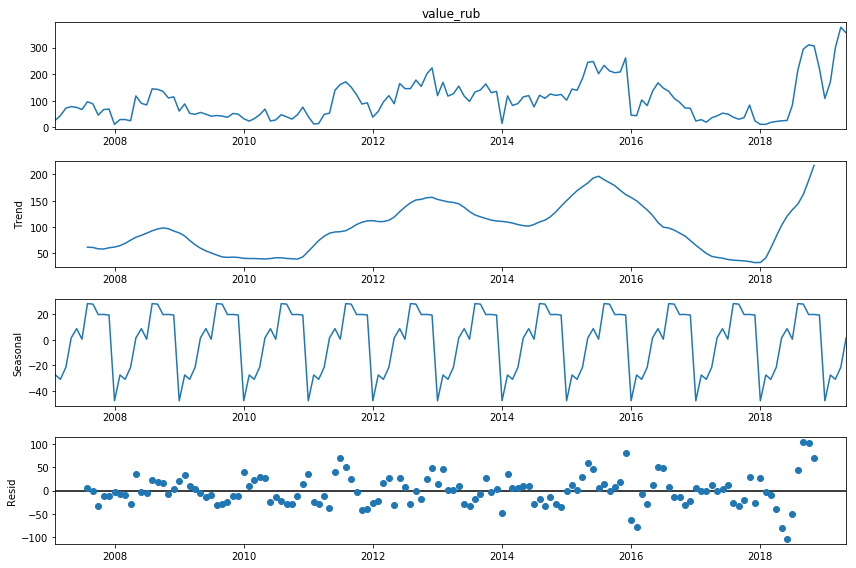

In [28]:
plt.figure(figsize(12,8))
sm.tsa.seasonal_decompose(sector_2.value_rub).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_2.value_rub)[1])

In [29]:
sector_2['value_rub_box'], lmbda = stats.boxcox(sector_2.value_rub)
# plt.figure(figsize(15,7))
# sector_2.value_rub_box.plot()
# plt.ylabel(u'Transformed for value_rub')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_2.value_rub_box)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.223018
Критерий Дики-Фуллера: p=0.002154


In [30]:
sector_2['value_rub_box_diff'] = sector_2.value_rub_box - sector_2.value_rub_box.shift(12)
# plt.figure(figsize(12,8))
# sm.tsa.seasonal_decompose(sector_2.value_rub_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_2.value_rub_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.156411


In [31]:
sector_2['value_rub_box_diff2'] = sector_2.value_rub_box_diff - sector_2.value_rub_box_diff.shift(1)
# plt.figure(figsize(12,8))
# sm.tsa.seasonal_decompose(sector_2.value_rub_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_2.value_rub_box_diff2[13:])[1])

Критерий Дики-Фуллера: p=0.005336


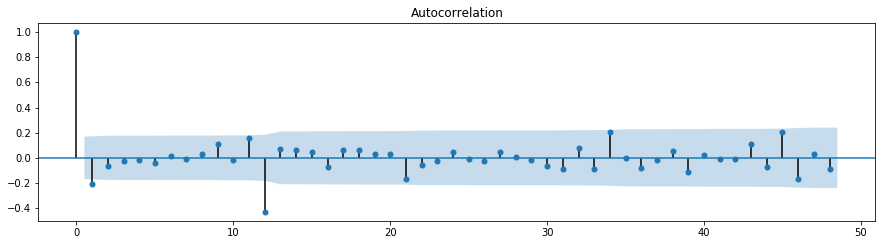

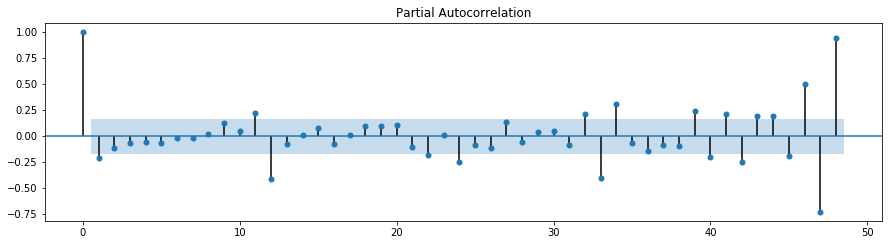

In [32]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(sector_2.value_rub_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(sector_2.value_rub_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [105]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
# len(parameters_list)

results = []
best_aic = float("inf")

from tqdm import tqdm
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sector_2.value_rub_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

100%|██████████████████████████████████████████| 40/40 [10:34<00:00, 48.30s/it]


      parameters         aic
11  (0, 1, 0, 1)  434.892529
21  (1, 0, 0, 1)  436.138283
31  (1, 1, 0, 1)  436.403720
13  (0, 1, 1, 1)  436.886078
19  (0, 1, 4, 1)  437.478533


In [33]:
model=sm.tsa.statespace.SARIMAX(sector_2.value_rub_box, order=(0, 1, 0), 
                                        seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
best_model = model

In [34]:
# plt.figure(figsize(15,8))
# plt.subplot(211)
# best_model.resid[13:].plot()
# plt.ylabel(u'Residuals')

# ax = plt.subplot(212)
# sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.869390
Критерий Дики-Фуллера: p=0.000000


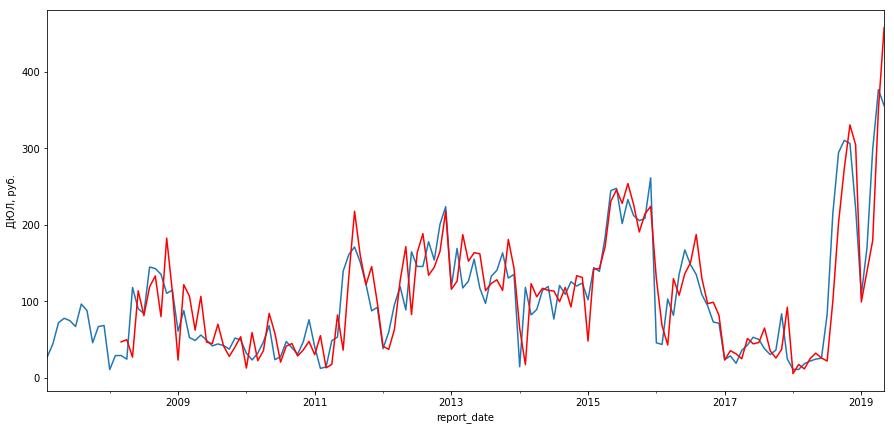

In [35]:
sector_2['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
sector_2.value_rub.plot()
sector_2.model[13:].plot(color='r')
plt.ylabel('ДЮЛ, руб.')
pylab.show()

In [ ]:
# sec_2 = sector_2[['value_rub']]
# date_list = [datetime.datetime.strptime("2019-06-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
# future = pd.DataFrame(index=date_list, columns= sec_2.columns)
# sec_2= pd.concat([sec_2, future])
# sec_2['forecast'] = invboxcox(best_model.predict(start=148, end=159), lmbda)

# plt.figure(figsize(15,7))
# sec_2.value_rub.plot()
# sec_2.forecast.plot(color='r')
# plt.ylabel('ДЮЛ, руб.')
# pylab.show()

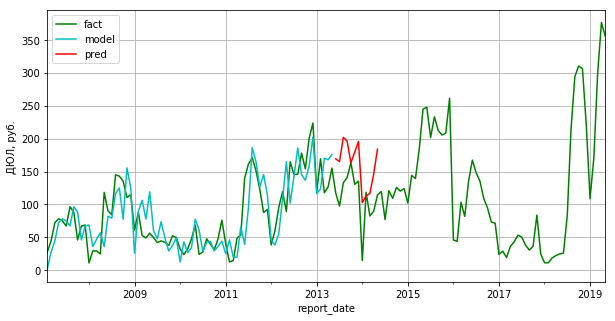

RMSE: 56.3403787746037


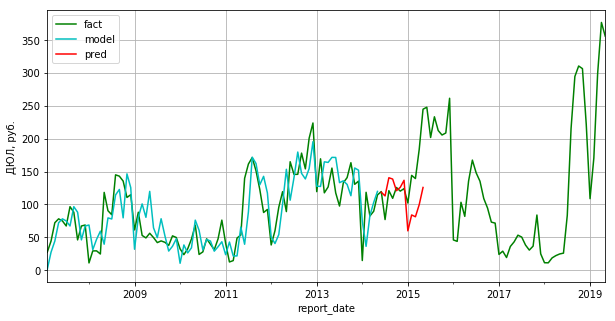

RMSE: 52.26257000096923


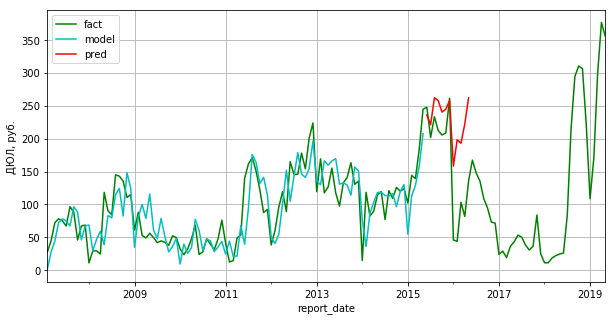

RMSE: 84.77861619795297


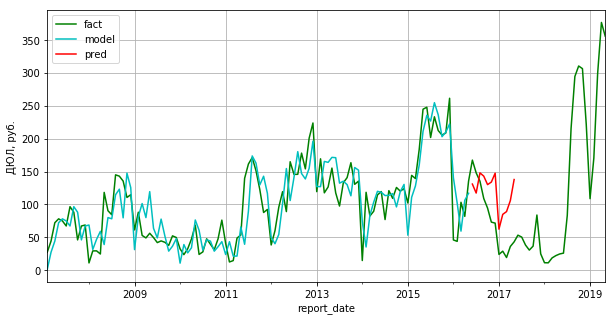

RMSE: 56.00869143134057


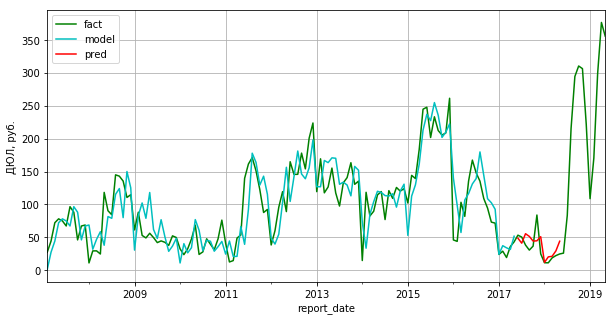

RMSE: 17.382156597439458


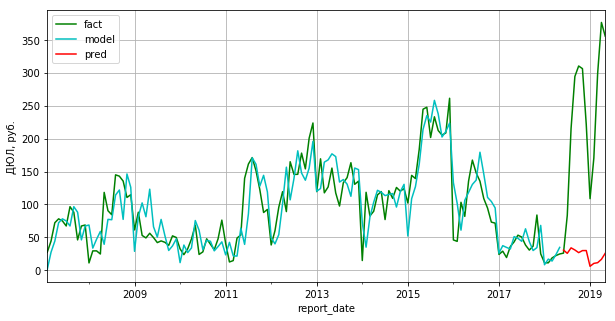

RMSE: 234.00051814794378

Средняя RMSE на исторических данных для горизонта прогнозирования в 1 год: 83.46215519170828


In [36]:
warnings.filterwarnings('ignore')

rmse_arr = []
sec_2 = sector_2[['value_rub']]
sec_2['forecast_cum'] = np.nan

for i in range(0, 72, 12):
    
    time_lapse = int(len(sector_2)/2) + 2 + i
    train, lmbda = stats.boxcox(sector_2.value_rub[:time_lapse])
    model=sm.tsa.statespace.SARIMAX(train, order=(0, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
    best_model = model
    
    sec_2['model'] = np.nan
    sec_2['forecast'] = np.nan
    
    if len(sector_2) - time_lapse < 12:
        end = len(sector_2) - time_lapse - 1
        sec_2['model'][:time_lapse] = invboxcox(best_model.fittedvalues, lmbda)
        sec_2['forecast'][time_lapse:]  = invboxcox(best_model.predict(start=time_lapse, end=time_lapse+end), lmbda)
        sec_2['forecast_cum'][time_lapse:] = sec_2['forecast'][time_lapse:] 
    else:
        sec_2['model'][:time_lapse] = invboxcox(best_model.fittedvalues, lmbda)
        sec_2['forecast'][time_lapse:(time_lapse+12)]  = invboxcox(best_model.predict(start=time_lapse, end=time_lapse+11), lmbda)
        sec_2['forecast_cum'][time_lapse:(time_lapse+12)] = sec_2['forecast'][time_lapse:(time_lapse+12)]
        
    plt.figure(figsize(10,5))
    sec_2.value_rub.plot(label = 'fact', color='g')
    sec_2.model.plot(label = 'model', color='c')
    sec_2.forecast.plot(label = 'pred', color='r')
    plt.ylabel('ДЮЛ, руб.')
    plt.legend()
    plt.grid()
    pylab.show()
    
    if len(sector_2) - time_lapse < 12:
        y_true = sec_2['value_rub'][time_lapse:]
        y_pred = sec_2['forecast'][time_lapse:]
    else:
        y_true = sec_2['value_rub'][time_lapse:(time_lapse + 12)]
        y_pred = sec_2['forecast'][time_lapse:(time_lapse + 12)]
        
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE:', rmse)
    rmse_arr.append(rmse)

print('\nСредняя RMSE на исторических данных для горизонта прогнозирования в 1 год:', np.mean(rmse_arr))

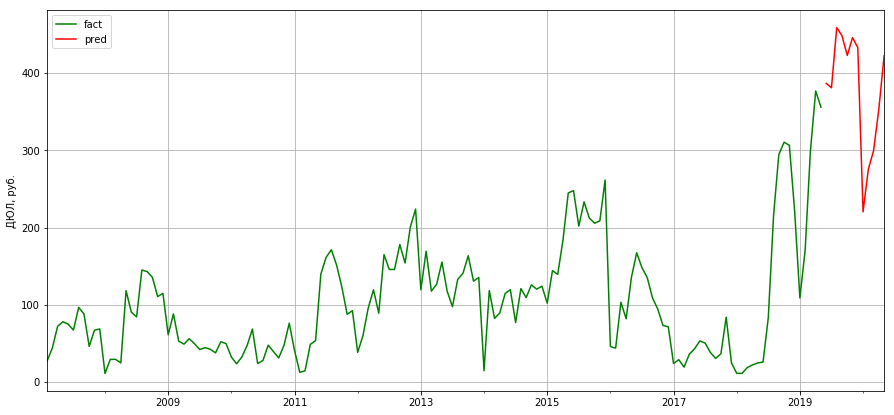

In [37]:
_, lmbda = stats.boxcox(sector_2.value_rub)

model=sm.tsa.statespace.SARIMAX(_, order=(0, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
best_model = model

# sec_2 = sector_2[['value_rub']]

date_list = [datetime.datetime.strptime("2019-06-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= sec_2.columns)
sec_2 = pd.concat([sec_2, future])
sec_2['forecast'] = np.nan

sec_2['forecast'][-12:] = invboxcox(best_model.predict(start=148, end=159), lmbda)
sec_2['forecast_cum'][-12:] = sec_2['forecast'][-12:]

plt.figure(figsize(15,7))
sec_2.value_rub.plot(label = 'fact', color='g')
sec_2.forecast.plot(label = 'pred', color='r')
plt.ylabel('ДЮЛ, руб.')
plt.legend()
plt.grid()
pylab.show()

## Sector_id - 3

Критерий Дики-Фуллера: p=0.886052


<Figure size 864x576 with 0 Axes>

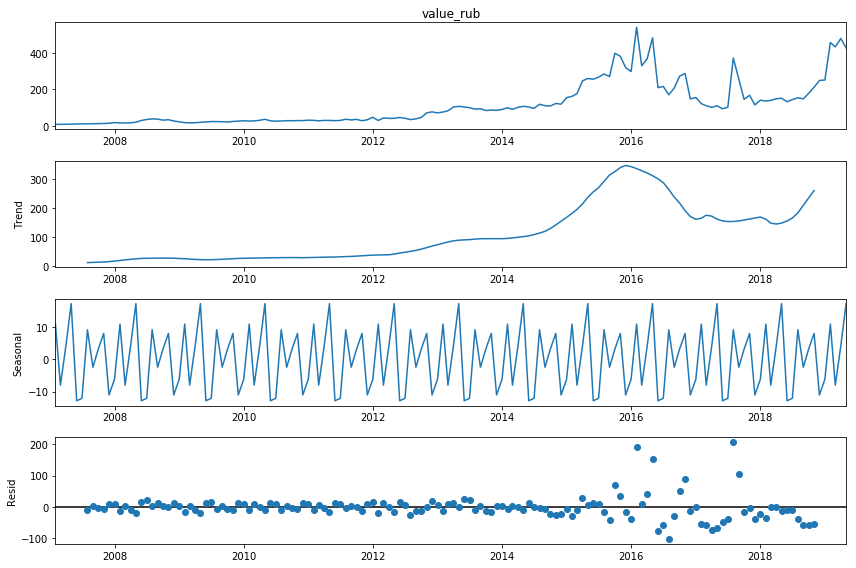

In [38]:
plt.figure(figsize(12,8))
sm.tsa.seasonal_decompose(sector_3.value_rub).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_3.value_rub)[1])

In [39]:
sector_3['value_rub_box'], lmbda = stats.boxcox(sector_3.value_rub)
# plt.figure(figsize(15,7))
# sector_3.value_rub_box.plot()
# plt.ylabel(u'Transformed for value_rub')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_3.value_rub_box)[1])

Оптимальный параметр преобразования Бокса-Кокса: -0.000369
Критерий Дики-Фуллера: p=0.617407


In [40]:
sector_3['value_rub_box_diff'] = sector_3.value_rub_box - sector_3.value_rub_box.shift(12)
# plt.figure(figsize(12,8))
# sm.tsa.seasonal_decompose(sector_3.value_rub_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_3.value_rub_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.065106


In [41]:
sector_3['value_rub_box_diff2'] = sector_3.value_rub_box_diff - sector_3.value_rub_box_diff.shift(1)
# plt.figure(figsize(12,8))
# sm.tsa.seasonal_decompose(sector_3.value_rub_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_3.value_rub_box_diff2[13:])[1])

Критерий Дики-Фуллера: p=0.000071


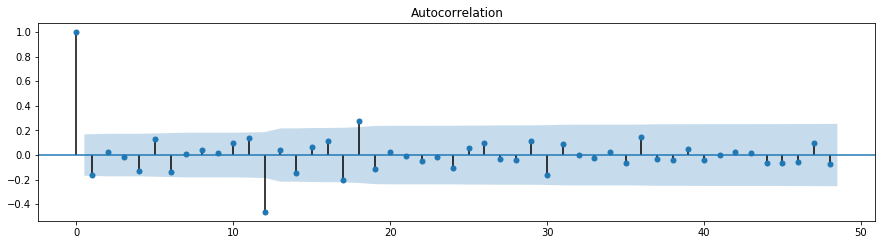

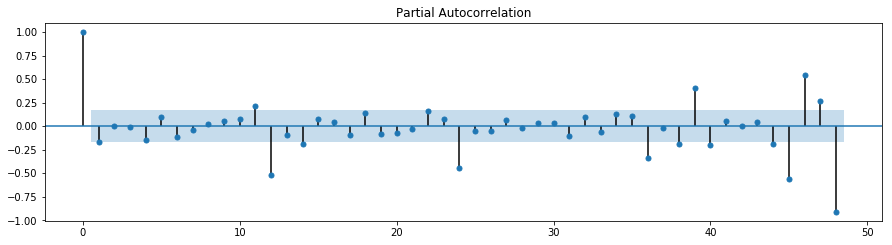

In [42]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(sector_3.value_rub_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(sector_3.value_rub_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [127]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
# len(parameters_list)

results = []
best_aic = float("inf")

from tqdm import tqdm
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sector_3.value_rub_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

100%|██████████████████████████████████████████| 40/40 [12:05<00:00, 46.18s/it]


      parameters       aic
15  (0, 1, 2, 1)  7.308623
5   (0, 0, 2, 1)  7.502574
25  (1, 0, 2, 1)  7.538217
17  (0, 1, 3, 1)  8.098543
7   (0, 0, 3, 1)  8.252851


In [43]:
model=sm.tsa.statespace.SARIMAX(sector_3.value_rub_box, order=(0, 1, 1), 
                                        seasonal_order=(2, 1, 1, 12)).fit(disp=-1)
best_model = model

In [44]:
# plt.figure(figsize(15,8))
# plt.subplot(211)
# best_model.resid[13:].plot()
# plt.ylabel(u'Residuals')

# ax = plt.subplot(212)
# sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.576089
Критерий Дики-Фуллера: p=0.000000


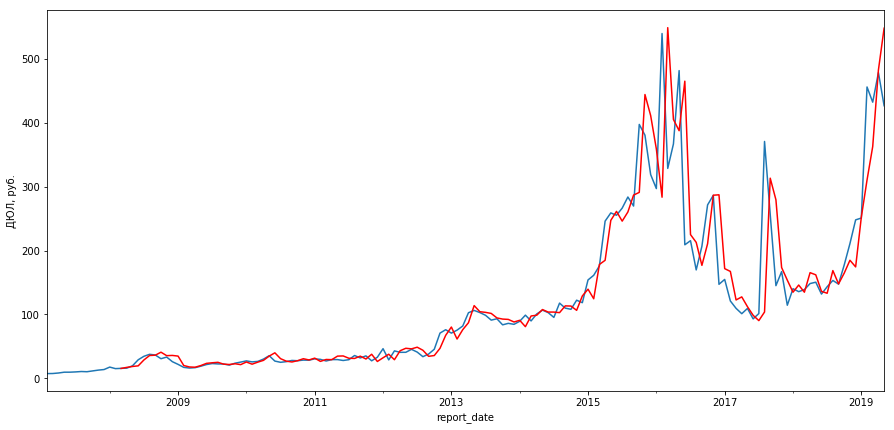

In [45]:
sector_3['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
sector_3.value_rub.plot()
sector_3.model[13:].plot(color='r')
plt.ylabel('ДЮЛ, руб.')
pylab.show()

In [ ]:
# sec_3 = sector_3[['value_rub']]
# date_list = [datetime.datetime.strptime("2019-06-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
# future = pd.DataFrame(index=date_list, columns= sec_3.columns)
# sec_3= pd.concat([sec_3, future])
# sec_3['forecast'] = invboxcox(best_model.predict(start=148, end=159), lmbda)

# plt.figure(figsize(15,7))
# sec_3.value_rub.plot()
# sec_3.forecast.plot(color='r')
# plt.ylabel('ДЮЛ, руб.')
# pylab.show()

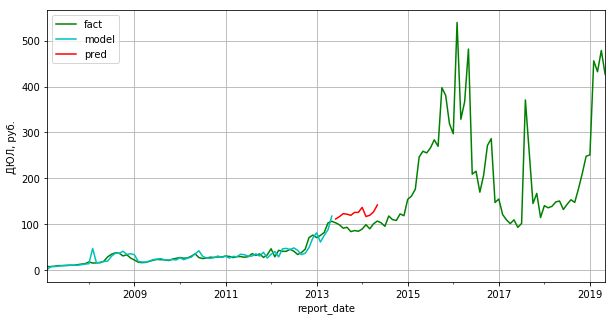

RMSE: 31.701410625385368


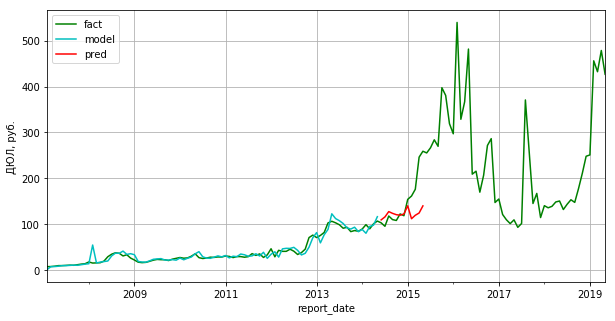

RMSE: 54.65299274851287


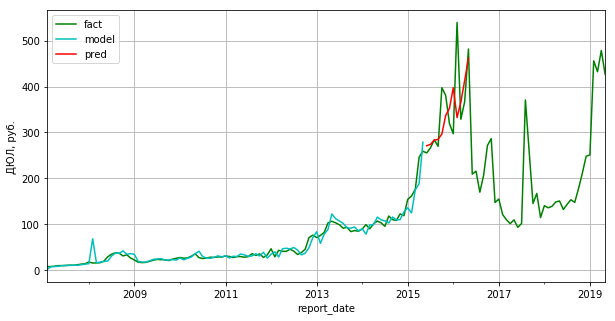

RMSE: 76.85445016211453


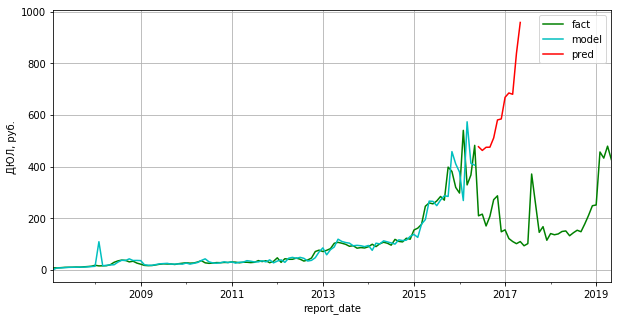

RMSE: 483.17940082330125


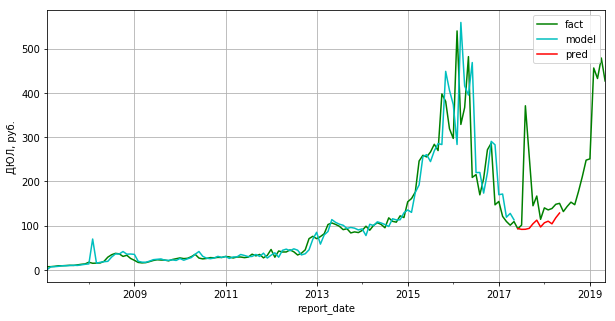

RMSE: 97.32370487497735


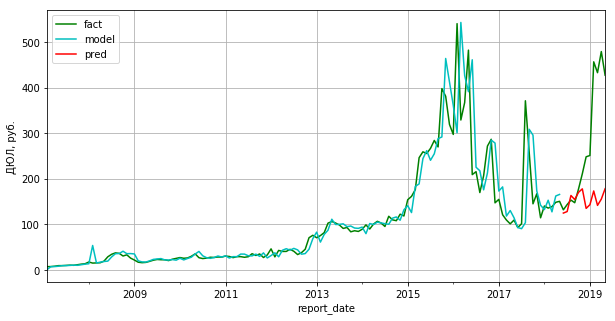

RMSE: 172.55973416891774

Средняя RMSE на исторических данных для горизонта прогнозирования в 1 год: 152.71194890053485


In [46]:
warnings.filterwarnings('ignore')

rmse_arr = []
sec_3 = sector_3[['value_rub']]
sec_3['forecast_cum'] = np.nan

for i in range(0, 72, 12):
    
    time_lapse = int(len(sector_3)/2) + 2 + i
    train, lmbda = stats.boxcox(sector_3.value_rub[:time_lapse])
    model=sm.tsa.statespace.SARIMAX(train, order=(0, 1, 1), 
                                        seasonal_order=(2, 1, 1, 12)).fit(disp=-1)
    best_model = model
    
    sec_3['model'] = np.nan
    sec_3['forecast'] = np.nan
    
    if len(sector_3) - time_lapse < 12:
        end = len(sector_3) - time_lapse - 1
        sec_3['model'][:time_lapse] = invboxcox(best_model.fittedvalues, lmbda)
        sec_3['forecast'][time_lapse:]  = invboxcox(best_model.predict(start=time_lapse, end=time_lapse+end), lmbda)
        sec_3['forecast_cum'][time_lapse:] = sec_3['forecast'][time_lapse:] 
    else:
        sec_3['model'][:time_lapse] = invboxcox(best_model.fittedvalues, lmbda)
        sec_3['forecast'][time_lapse:(time_lapse+12)]  = invboxcox(best_model.predict(start=time_lapse, end=time_lapse+11), lmbda)
        sec_3['forecast_cum'][time_lapse:(time_lapse+12)] = sec_3['forecast'][time_lapse:(time_lapse+12)]
        
    plt.figure(figsize(10,5))
    sec_3.value_rub.plot(label = 'fact', color='g')
    sec_3.model.plot(label = 'model', color='c')
    sec_3.forecast.plot(label = 'pred', color='r')
    plt.ylabel('ДЮЛ, руб.')
    plt.legend()
    plt.grid()
    pylab.show()
    
    if len(sector_3) - time_lapse < 12:
        y_true = sec_3['value_rub'][time_lapse:]
        y_pred = sec_3['forecast'][time_lapse:]
    else:
        y_true = sec_3['value_rub'][time_lapse:(time_lapse + 12)]
        y_pred = sec_3['forecast'][time_lapse:(time_lapse + 12)]
        
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE:', rmse)
    rmse_arr.append(rmse)

print('\nСредняя RMSE на исторических данных для горизонта прогнозирования в 1 год:', np.mean(rmse_arr))

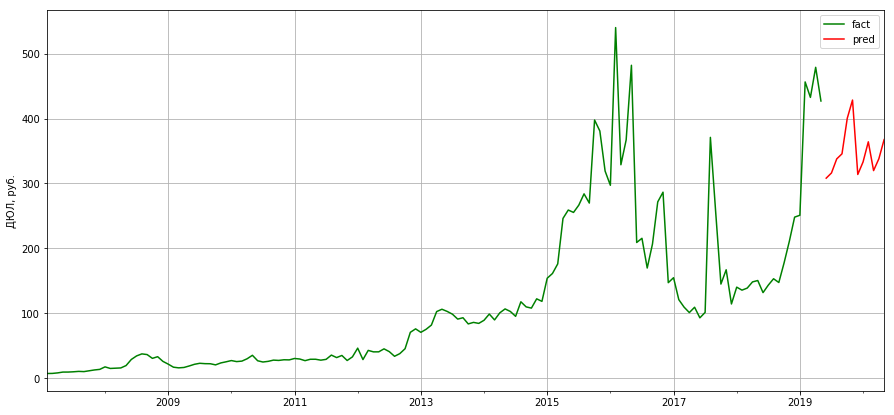

In [47]:
_, lmbda = stats.boxcox(sector_3.value_rub)

model=sm.tsa.statespace.SARIMAX(_, order=(0, 1, 1), 
                                        seasonal_order=(2, 1, 1, 12)).fit(disp=-1)
best_model = model

# sec_3 = sector_3[['value_rub']]

date_list = [datetime.datetime.strptime("2019-06-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= sec_3.columns)
sec_3 = pd.concat([sec_3, future])
sec_3['forecast'] = np.nan

sec_3['forecast'][-12:] = invboxcox(best_model.predict(start=148, end=159), lmbda)
sec_3['forecast_cum'][-12:] = sec_3['forecast'][-12:]

plt.figure(figsize(15,7))
sec_3.value_rub.plot(label = 'fact', color='g')
sec_3.forecast.plot(label = 'pred', color='r')
plt.ylabel('ДЮЛ, руб.')
plt.legend()
plt.grid()
pylab.show()

## Sector_id - 4

Критерий Дики-Фуллера: p=0.935152


<Figure size 864x576 with 0 Axes>

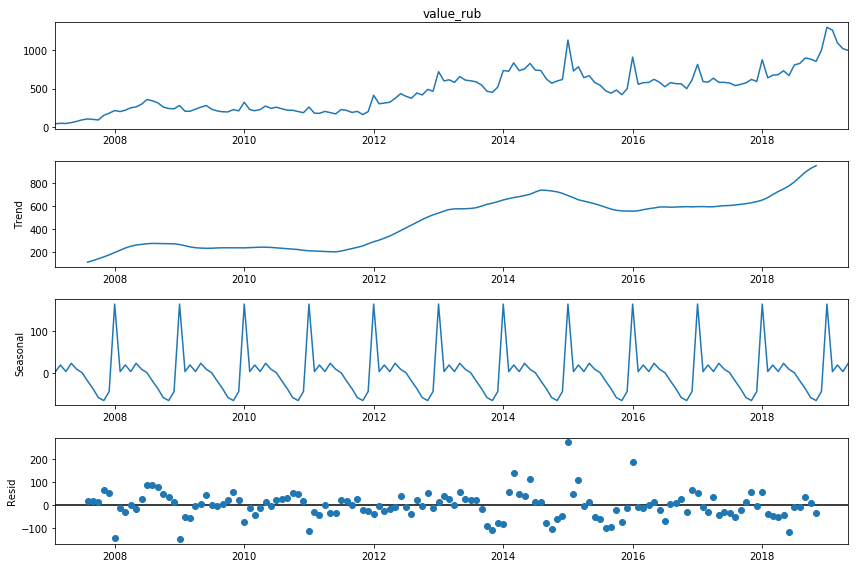

In [48]:
plt.figure(figsize(12,8))
sm.tsa.seasonal_decompose(sector_4.value_rub).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_4.value_rub)[1])

In [49]:
sector_4['value_rub_box'], lmbda = stats.boxcox(sector_4.value_rub)
# plt.figure(figsize(15,7))
# sector_4.value_rub_box.plot()
# plt.ylabel(u'Transformed for value_rub')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_4.value_rub_box)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.462197
Критерий Дики-Фуллера: p=0.870870


In [50]:
sector_4['value_rub_box_diff'] = sector_4.value_rub_box - sector_4.value_rub_box.shift(12)
# plt.figure(figsize(12,8))
# sm.tsa.seasonal_decompose(sector_4.value_rub_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_4.value_rub_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.099540


In [51]:
sector_4['value_rub_box_diff2'] = sector_4.value_rub_box_diff - sector_4.value_rub_box_diff.shift(1)
# plt.figure(figsize(12,8))
# sm.tsa.seasonal_decompose(sector_4.value_rub_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sector_4.value_rub_box_diff2[13:])[1])

Критерий Дики-Фуллера: p=0.000026


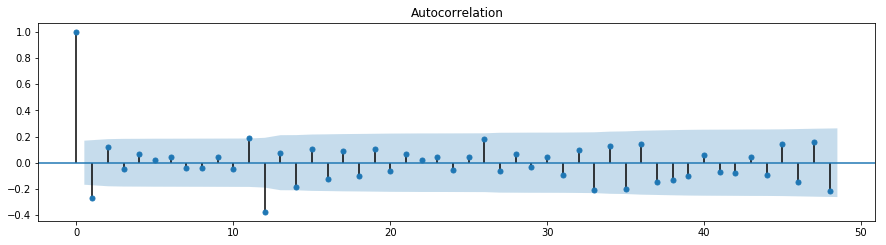

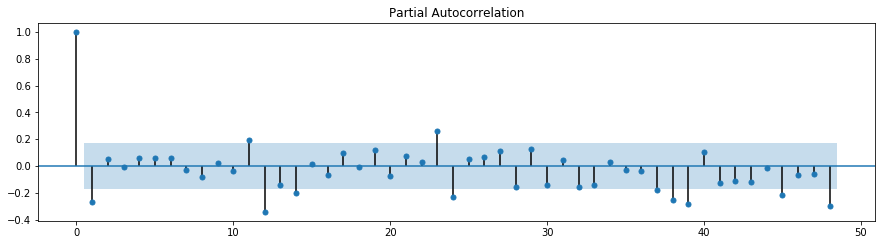

In [52]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(sector_4.value_rub_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(sector_4.value_rub_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [143]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
# len(parameters_list)

results = []
best_aic = float("inf")

from tqdm import tqdm
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sector_4.value_rub_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

100%|██████████████████████████████████████████| 40/40 [05:56<00:00, 23.51s/it]


      parameters         aic
21  (1, 0, 0, 1)  604.136839
28  (1, 0, 4, 0)  604.323975
18  (0, 1, 4, 0)  604.747638
11  (0, 1, 0, 1)  604.882440
23  (1, 0, 1, 1)  605.087438


In [53]:
model=sm.tsa.statespace.SARIMAX(sector_4.value_rub_box, order=(1, 1, 0), 
                                        seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
best_model = model

In [54]:
# plt.figure(figsize(15,8))
# plt.subplot(211)
# best_model.resid[13:].plot()
# plt.ylabel(u'Residuals')

# ax = plt.subplot(212)
# sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.390634
Критерий Дики-Фуллера: p=0.000000


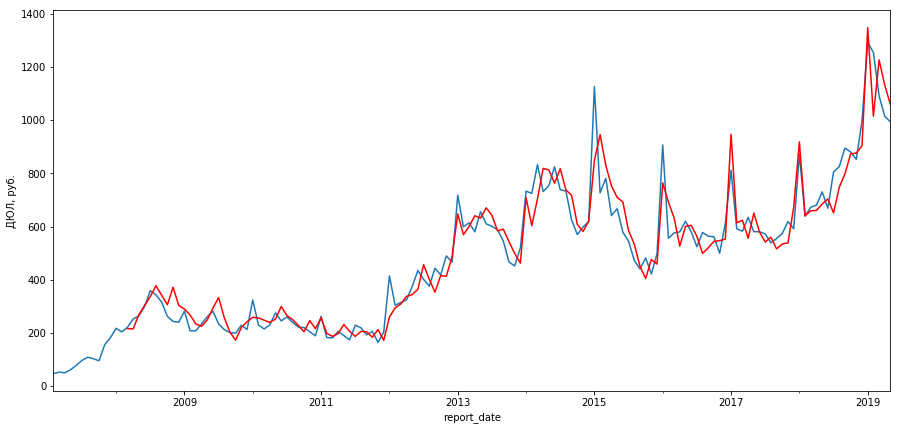

In [55]:
sector_4['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
sector_4.value_rub.plot()
sector_4.model[13:].plot(color='r')
plt.ylabel('ДЮЛ, руб.')
pylab.show()

In [ ]:
# sec_4 = sector_4[['value_rub']]
# date_list = [datetime.datetime.strptime("2019-06-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
# future = pd.DataFrame(index=date_list, columns= sec_4.columns)
# sec_4 = pd.concat([sec_4, future])
# sec_4['forecast'] = invboxcox(best_model.predict(start=148, end=159), lmbda)

# plt.figure(figsize(15,7))
# sec_4.value_rub.plot()
# sec_4.forecast.plot(color='r')
# plt.ylabel('ДЮЛ, руб.')
# pylab.show()

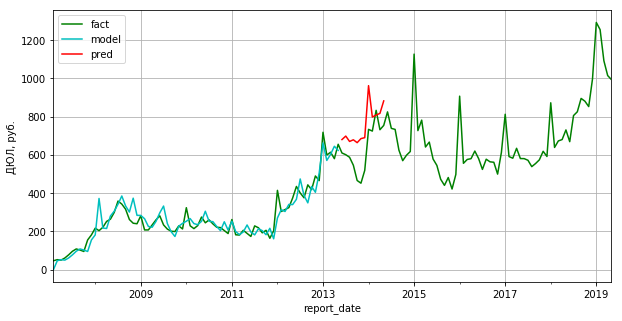

RMSE: 142.38857838090348


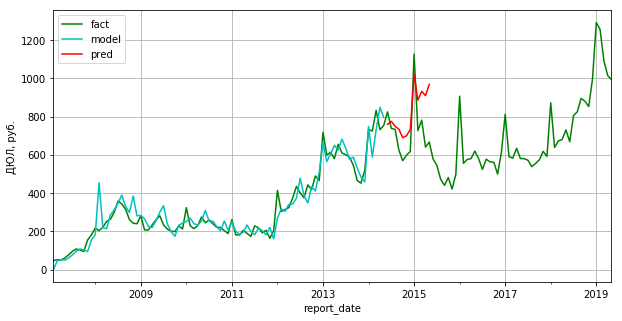

RMSE: 152.15339747422885


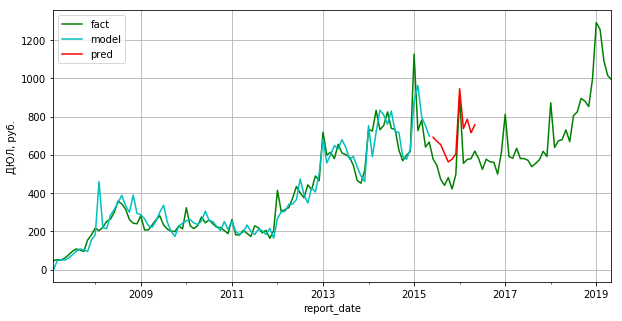

RMSE: 143.77411126750187


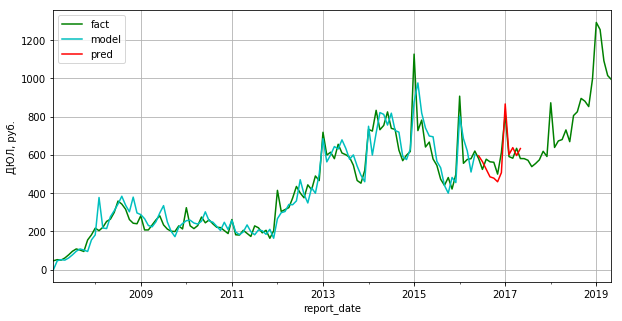

RMSE: 58.21698095994088


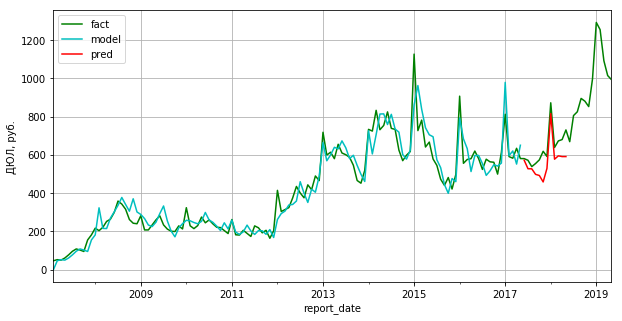

RMSE: 82.62283533286792


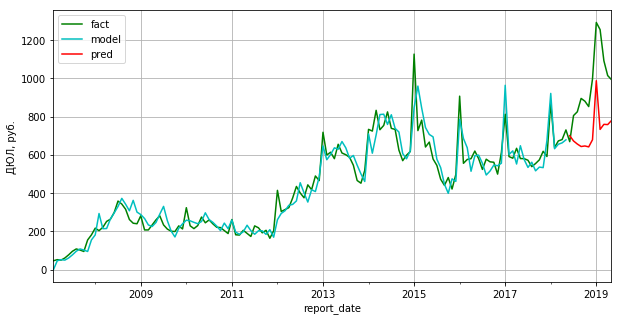

RMSE: 273.23117110618125

Средняя RMSE на исторических данных для горизонта прогнозирования в 1 год: 142.06451242027072


In [56]:
warnings.filterwarnings('ignore')

rmse_arr = []
sec_4 = sector_4[['value_rub']]
sec_4['forecast_cum'] = np.nan

for i in range(0, 72, 12):
    
    time_lapse = int(len(sector_4)/2) + 2 + i
    train, lmbda = stats.boxcox(sector_4.value_rub[:time_lapse])
    model=sm.tsa.statespace.SARIMAX(train, order=(1, 1, 0), 
                                        seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
    best_model = model
    
    sec_4['model'] = np.nan
    sec_4['forecast'] = np.nan
    
    if len(sector_4) - time_lapse < 12:
        end = len(sector_4) - time_lapse - 1
        sec_4['model'][:time_lapse] = invboxcox(best_model.fittedvalues, lmbda)
        sec_4['forecast'][time_lapse:]  = invboxcox(best_model.predict(start=time_lapse, end=time_lapse+end), lmbda)
        sec_4['forecast_cum'][time_lapse:] = sec_4['forecast'][time_lapse:]
    else:
        sec_4['model'][:time_lapse] = invboxcox(best_model.fittedvalues, lmbda)
        sec_4['forecast'][time_lapse:(time_lapse+12)]  = invboxcox(best_model.predict(start=time_lapse, end=time_lapse+11), lmbda)
        sec_4['forecast_cum'][time_lapse:(time_lapse+12)] = sec_4['forecast'][time_lapse:(time_lapse+12)]
        
    plt.figure(figsize(10,5))
    sec_4.value_rub.plot(label = 'fact', color='g')
    sec_4.model.plot(label = 'model', color='c')
    sec_4.forecast.plot(label = 'pred', color='r')
    plt.ylabel('ДЮЛ, руб.')
    plt.legend()
    plt.grid()
    pylab.show()
    
    if len(sector_4) - time_lapse < 12:
        y_true = sec_4['value_rub'][time_lapse:]
        y_pred = sec_4['forecast'][time_lapse:]
    else:
        y_true = sec_4['value_rub'][time_lapse:(time_lapse + 12)]
        y_pred = sec_4['forecast'][time_lapse:(time_lapse + 12)]
        
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE:', rmse)
    rmse_arr.append(rmse)

print('\nСредняя RMSE на исторических данных для горизонта прогнозирования в 1 год:', np.mean(rmse_arr))

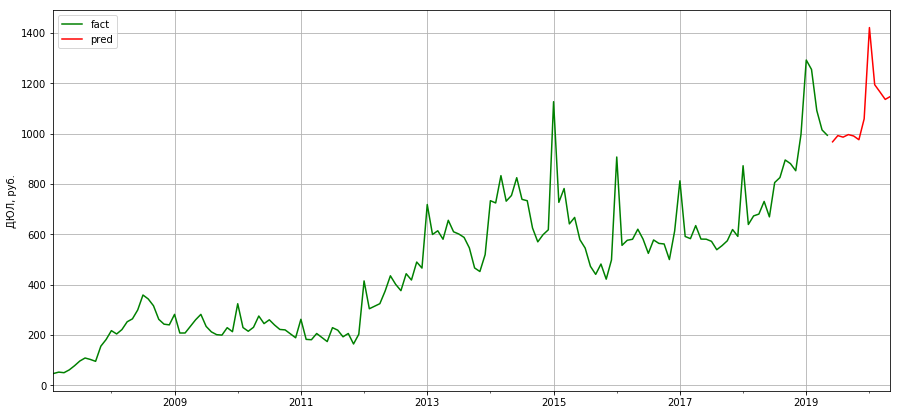

In [57]:
_, lmbda = stats.boxcox(sector_4.value_rub)

model=sm.tsa.statespace.SARIMAX(_, order=(1, 1, 0), 
                                        seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
best_model = model

# sec_4 = sector_4[['value_rub']]

date_list = [datetime.datetime.strptime("2019-06-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= sec_4.columns)
sec_4 = pd.concat([sec_4, future])
sec_4['forecast'] = np.nan

sec_4['forecast'][-12:] = invboxcox(best_model.predict(start=148, end=159), lmbda)
sec_4['forecast_cum'][-12:] = sec_4['forecast'][-12:]

plt.figure(figsize(15,7))
sec_4.value_rub.plot(label = 'fact', color='g')
sec_4.forecast.plot(label = 'pred', color='r')
plt.ylabel('ДЮЛ, руб.')
plt.legend()
plt.grid()
pylab.show()

In [58]:
sec_forecast_sum = sec_2['forecast_cum']+sec_3['forecast_cum']+sec_4['forecast_cum'] 

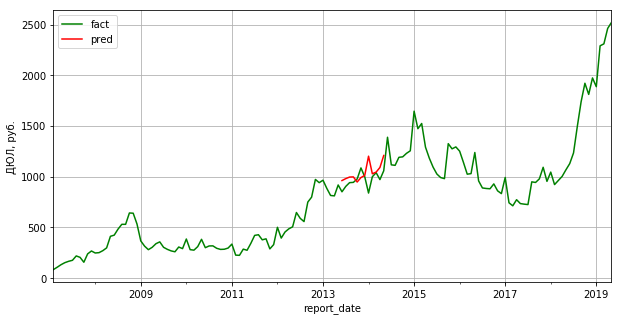

RMSE: 130.5135226649738


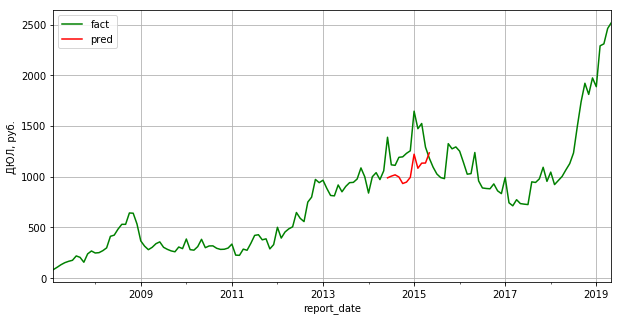

RMSE: 281.4775125077815


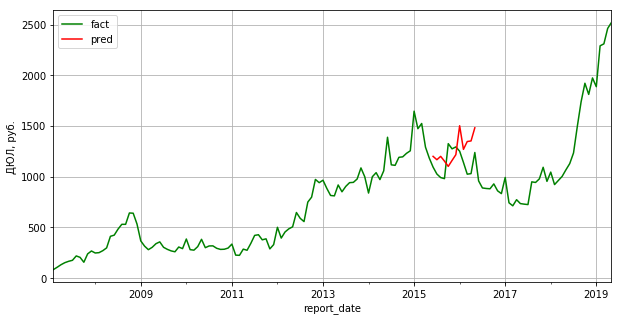

RMSE: 208.3365294663061


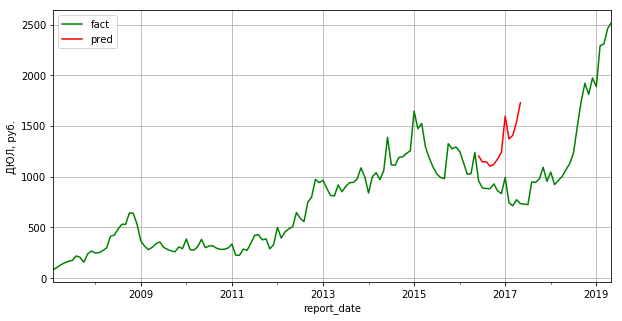

RMSE: 530.6146767302425


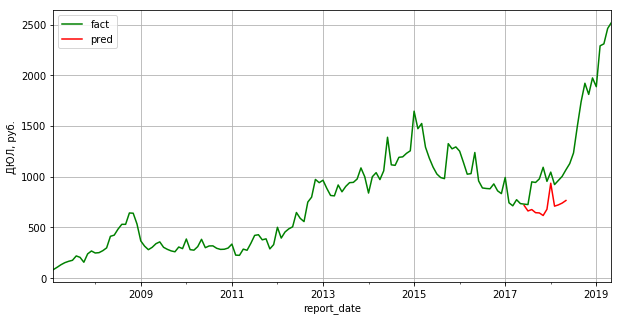

RMSE: 267.55235686319867


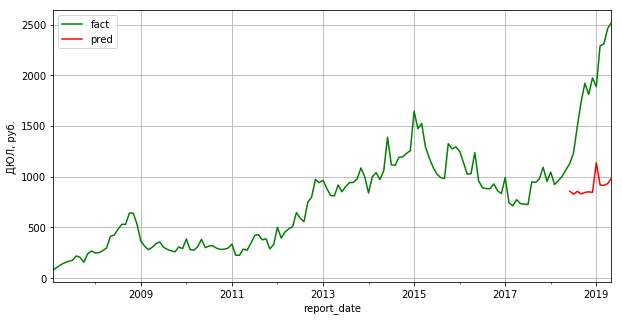

RMSE: 1078.020874107092

Средняя RMSE на исторических данных для горизонта прогнозирования в 1 год: 416.08591205659906


In [59]:
warnings.filterwarnings('ignore')

rmse_arr = []
sec_sum = sectors_sum[['value_rub']]
sec_for_sum = sec_forecast_sum[:-12]

for i in range(0, 72, 12):
    
    time_lapse = int(len(sec_sum)/2) + 2 + i
        
    if len(sec_sum) - time_lapse < 12:
        plt.figure(figsize(10,5))
        sec_sum.value_rub.plot(label = 'fact', color='g')
        sec_for_sum[time_lapse:].plot(label = 'pred', color='r')
        plt.ylabel('ДЮЛ, руб.')
        plt.legend()
        plt.grid()
        pylab.show()
    else:
        plt.figure(figsize(10,5))
        sec_sum.value_rub.plot(label = 'fact', color='g')
        sec_for_sum[time_lapse:(time_lapse+12)].plot(label = 'pred', color='r')
        plt.ylabel('ДЮЛ, руб.')
        plt.legend()
        plt.grid()
        pylab.show()
    
    if len(sector_4) - time_lapse < 12:
        y_true = sec_sum[time_lapse:]
        y_pred = sec_for_sum[time_lapse:]
    else:
        y_true = sec_sum[time_lapse:(time_lapse + 12)]
        y_pred = sec_for_sum[time_lapse:(time_lapse + 12)]
        
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE:', rmse)
    rmse_arr.append(rmse)

print('\nСредняя RMSE на исторических данных для горизонта прогнозирования в 1 год:', np.mean(rmse_arr))

## Прогноз из суммы моделей

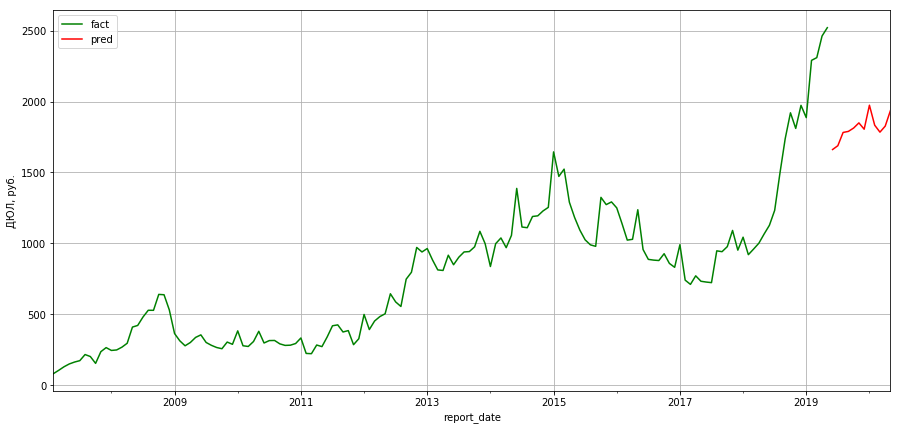

In [60]:
plt.figure(figsize(15,7))
sectors_sum.value_rub.plot(label = 'fact', color='g')
sec_forecast_sum[-12:].plot(label = 'pred', color='r')
plt.ylabel('ДЮЛ, руб.')
plt.legend()
plt.grid()
pylab.show()